In [1]:
## Download data
!wget https://raw.githubusercontent.com/cecicxy/Virtual-Currency-Practise/main/datasets/ETHUSDT_1H.csv

In [ ]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
## 采用TPU训练时执行下面的代码
!pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp310-cp310-linux_x86_64.whl (162.9 MB)


In [ ]:
## TPU训练时执行下面的代码
# imports pytorch
import torch
# imports the torch_xla package
import torch_xla
import torch_xla.core.xla_model as xm
# Creates a random tensor on xla:1 (a Cloud TPU core)
dev = xm.xla_device()
dev



device(type='xla', index=1)

In [ ]:
## GPU 训练时执行下面的代码
import torch
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True

In [ ]:
dev = torch.device('cuda:0')
dev

device(type='cuda', index=0)

In [ ]:
import pandas as pd
## 导入数据
data = pd.read_csv('ETHUSDT_1H.csv',index_col='date')
data.index= pd.to_datetime(data.index)
data = data.asfreq('H').interpolate('linear')
import numpy as np
data['day']=data.index.day
data['hour']=data.index.hour
data['weekday']=data.index.weekday
data['month']= data.index.month
data['season']= data.index.month%12 // 3 + 1
data['time_idx']= np.arange(len(data.index))
## 导入库
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
rawdata = data.copy()

In [ ]:
data = rawdata.iloc[:,:6]

In [ ]:
featureddata = data

In [ ]:
featureddata['price']= data.iloc[:,0]+data.iloc[:,1]+data.iloc[:,2]+data.iloc[:,3]
featureddata['price'] = featureddata['price']/4

In [ ]:
featureddata['price']

date
2022-05-27 17:00:00+08:00    1775.2000
2022-05-27 18:00:00+08:00    1770.8975
2022-05-27 19:00:00+08:00    1772.6275
2022-05-27 20:00:00+08:00    1786.8700
2022-05-27 21:00:00+08:00    1803.6600
                               ...    
2023-06-10 10:00:00+08:00    1833.1400
2023-06-10 11:00:00+08:00    1828.2200
2023-06-10 12:00:00+08:00    1807.4050
2023-06-10 13:00:00+08:00    1764.3900
2023-06-10 14:00:00+08:00    1748.8100
Freq: H, Name: price, Length: 9094, dtype: float64

In [ ]:
featureddata

,open,high,low,close,volume,currency_volume,price
date,,,,,,,
2022-05-27 17:00:00+08:00,1766.05,1810.19,1740.00,1784.56,1256964.0,125696.40,1775.2000
2022-05-27 18:00:00+08:00,1784.83,1799.00,1740.00,1759.76,1192301.0,119230.10,1770.8975
2022-05-27 19:00:00+08:00,1759.76,1809.00,1750.12,1771.63,1148144.0,114814.40,1772.6275
2022-05-27 20:00:00+08:00,1771.44,1823.00,1740.18,1812.86,1965047.0,196504.70,1786.8700
2022-05-27 21:00:00+08:00,1813.06,1824.00,1762.66,1814.92,1868081.0,186808.10,1803.6600
...,...,...,...,...,...,...,...
2023-06-10 10:00:00+08:00,1835.93,1840.00,1826.66,1829.97,12191333.0,121913.33,1833.1400
2023-06-10 11:00:00+08:00,1829.77,1833.33,1822.40,1827.38,12069916.0,120699.16,1828.2200
2023-06-10 12:00:00+08:00,1827.37,1832.00,1781.79,1788.46,41509852.0,415098.52,1807.4050


In [ ]:
data = data.rolling(24*7).mean().dropna()

In [ ]:
data

,open,high,low,close,volume,currency_volume
date,,,,,,
2022-06-03 16:00:00+08:00,1849.260060,1868.057381,1831.865298,1849.576190,1.221780e+06,122177.963095
2022-06-03 17:00:00+08:00,1849.261654,1868.057774,1831.865941,1849.576680,1.221828e+06,122182.785112
2022-06-03 18:00:00+08:00,1849.263728,1868.058239,1831.866939,1849.577267,1.221924e+06,122192.383670
2022-06-03 19:00:00+08:00,1849.265903,1868.058209,1831.867933,1849.577508,1.222076e+06,122207.641681
2022-06-03 20:00:00+08:00,1849.267743,1868.057186,1831.868365,1849.575349,1.222271e+06,122227.058170
...,...,...,...,...,...,...
2023-06-10 10:00:00+08:00,1875.258936,1881.427122,1868.493133,1875.230958,8.687235e+06,86872.353007
2023-06-10 11:00:00+08:00,1875.200741,1881.362820,1868.437944,1875.168097,8.698169e+06,86981.692438
2023-06-10 12:00:00+08:00,1875.137659,1881.293771,1868.376472,1875.098825,8.710314e+06,87103.140106


<Axes: xlabel='date'>

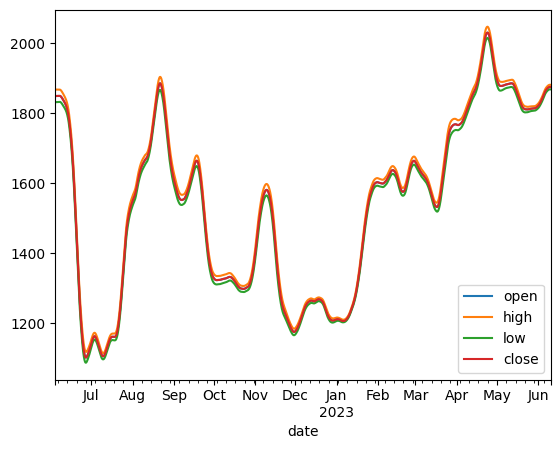

In [ ]:
data.iloc[:,:4].plot()

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
minmax= MinMaxScaler()
data =minmax.fit_transform(data)

In [ ]:
def dataloader(data,features,targets, seqlen,prelen,device):
    X=[]
    for i in range(len(data)-prelen):
      X.append((torch.tensor(data[i:i+seqlen,:].astype('float32'),device=device),torch.tensor(data[i+seqlen:i+seqlen+prelen,:].astype('float32'),device=device)))
    return X


In [ ]:
from torch.utils.data import DataLoader
alldata = dataloader(data,None,None, 24*14,24*7,dev)

In [ ]:
import torch.nn.functional as nf
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size,predlen,device,dropout=0):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # 单向LSTM
        self.device = device
        self.predlen = predlen
        self.hiddenhalfsize = int(self.hidden_size/2)
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers,dropout=dropout, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        self.lineartrans = nn.Linear(self.output_size, self.output_size)
        # self.to(device)
    def forward(self, input_seq):

        batch_size, seq_len = input_seq.shape[0], input_seq.shape[1]
        h_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(self.device)
        c_0 = torch.randn(self.num_directions * self.num_layers, batch_size, self.hidden_size).to(self.device)
        # output(batch_size, seq_len, num_directions * hidden_size)
        output, _ = self.lstm(input_seq, (h_0, c_0)) # output(5, 30, 64)
        pred = nf.leaky_relu(self.linear(output))  # (6, 30, 1)
        # pred = nf.leaky_relu(self.linearNext(pred))
        pred = pred[:, -self.predlen:, :] # (6, 1)
        # pred = nf.leaky_relu(self.lineartrans(pred))
        return pred


In [ ]:

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint2.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
from tqdm  import tqdm
def train(model,dataloader,validataloader,device,epochNum=10,learningrate=1e-3,decay=0.02,patience=10):
    print(model,dataloader,validataloader,device)
    loss_function = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learningrate,
                                      weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
  # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    print(type(dataloader))
    batchsize = dataloader.batch_size
    for epoch in range(epochNum):
        model.train() # prep model for training
        for batch, (data, target) in tqdm(enumerate(dataloader,1),desc=f'epoch {epoch}:'):
            # if batch >=int(len(dataloader.dataset)/batchsize):
            #     break
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = loss_function(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
        model.eval() # prep model for evaluation
        for batch, (data, target)in tqdm(enumerate(validataloader,1),desc=f'epoch {epoch}: validate'):
            # if batch >=int(len(validataloader.dataset)/batchsize):
            #     break
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = loss_function(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        print_msg = (f'epoch: [{epoch}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        scheduler.step()
      # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint2.pt'))
    return  model, avg_train_losses, avg_valid_losses


In [ ]:
ratio =0.8,0.9,1.0
batch_size = 128
spidx = [int(len(normdata)*i) for i in ratio]
train_dataloader =  DataLoader(alldata[:spidx[0]], batch_size=batch_size, shuffle=True)
validate_dataloader = DataLoader(alldata[spidx[0]:spidx[1]], batch_size=batch_size , shuffle=True)
test_dataloader = DataLoader(alldata[spidx[1]:spidx[2]], batch_size=batch_size , shuffle=False)
seqlen,inputsize = train_dataloader.dataset[0][0].size()
predlen,outputsize = train_dataloader.dataset[0][1].size()
lstmModel = LSTM(inputsize,128,1,outputsize,predlen,dev).to(dev)
# lstmModel.load_state_dict(torch.load('checkpoint.pt'))
model, avg_train_losses, avg_valid_losses = train(lstmModel,train_dataloader,validate_dataloader,dev,epochNum=40,learningrate=1e-1,patience=20)

In [ ]:
def testLoss(model,testdataloader,device):
    loss_function = nn.MSELoss().to(device)
    batchsize = testdataloader.batch_size
    sum=0
    for batch, (data, target)in tqdm(enumerate(testdataloader,1),desc=f'test validate'):
        if batch >= 4:
            break
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = loss_function(output, target)
        # record validation loss
        sum+=loss.item()
    return sum/batch


In [ ]:
realLoss = testLoss(model,test_dataloader,dev)
realLoss

test validate: 3it [00:00, 71.85it/s]


0.01955291535705328

In [ ]:
def roolingTest():
    start,end= spidx[1],spidx[2]
    initdata = np.array(data[start-seqlen:start]).astype('float32')
    for i in range(0,end-start,predlen):
        udata = torch.tensor(initdata[i:i+seqlen].reshape(1,seqlen,-1)).to(dev)
        pred = model(udata)
        initdata= np.vstack([initdata,pred.data.cpu()[0].numpy()])
    return initdata


In [ ]:
def SingleTest(start,end):
    initdata = None
    for i in range(start,end,predlen):
        udata = torch.tensor(np.array(data[i-seqlen:i]).astype('float32').reshape(1,seqlen,-1)).to(dev)
        pred = model(udata)
        if initdata is not None:
            initdata= np.vstack([initdata,pred.data.cpu()[0].numpy()])
        else:
            initdata= pred.data.cpu()[0].numpy()
    return initdata

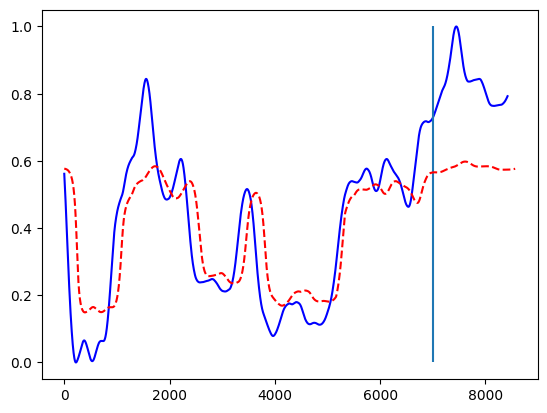

In [ ]:
import matplotlib.pyplot as plt
start,end=  seqlen,spidx[2]
initdata = SingleTest(start,end)
plt.plot(data[start:end][:,0],'b-')
plt.vlines(x=spidx[0],ymin=0,ymax=1)
plt.plot(initdata[:,0],'r--')
